In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import rasterio
import rasterio.features
import rasterio.warp
import rasterio.plot
import rasterio.mask
from rasterio.enums import MergeAlg
from rasterio.plot import show
from numpy import int16
from pyproj import CRS, Proj
import shapely
from shapely.geometry import Polygon, box
from shapely.geometry import mapping as geojson_mapping
import fiona
from descartes import PolygonPatch
from matplotlib import collections as cplt
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps

## Reading RUV shapefile

In [2]:
ruv_shp = gpd.read_file('shapefile/RUV.shp')

In [3]:
ruv_shp.head()

,OBJECTID,Gov,Markaz,Class,Class_id,FID,Area,geometry
0,1.0,Sharkia,Al Hasnia,Cultivated_area,1,1,8469.92,"POLYGON ((399189.965 3420621.940, 399219.483 3..."
1,2.0,Sharkia,Al Hasnia,Cultivated_area,1,2,18210.39,"POLYGON ((391110.986 3419106.380, 391167.549 3..."
2,3.0,Sharkia,Al Hasnia,Cultivated_area,1,3,5319.87,"POLYGON ((391246.442 3418833.177, 391310.235 3..."
3,4.0,Sharkia,Al Hasnia,Cultivated_area,1,4,4617.19,"POLYGON ((391303.547 3419113.815, 391266.506 3..."
4,5.0,Sharkia,Al Hasnia,Cultivated_area,1,5,5511.34,"POLYGON ((390954.534 3418762.559, 391017.703 3..."


In [4]:
ruv_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11637 entries, 0 to 11636
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  1018 non-null   float64 
 1   Gov       11618 non-null  object  
 2   Markaz    11629 non-null  object  
 3   Class     11637 non-null  object  
 4   Class_id  11637 non-null  int64   
 5   FID       11637 non-null  int64   
 6   Area      11626 non-null  float64 
 7   geometry  11637 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 727.4+ KB


In [5]:
ruv_shp.shape

(11637, 8)

In [6]:
ruv_shp.isnull().values.any()

True

<Axes: >

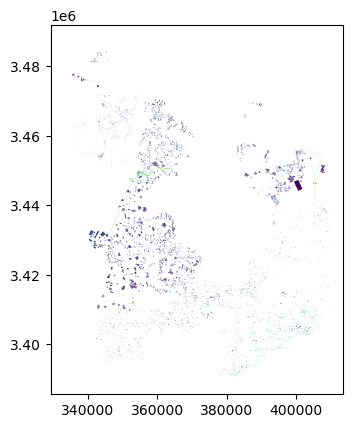

In [7]:
ruv_shp.plot('Class', cmap='viridis')

<Axes: >

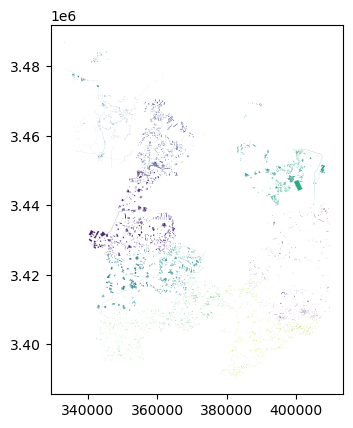

In [8]:
ruv_shp['geometry'].plot(cmap='viridis')

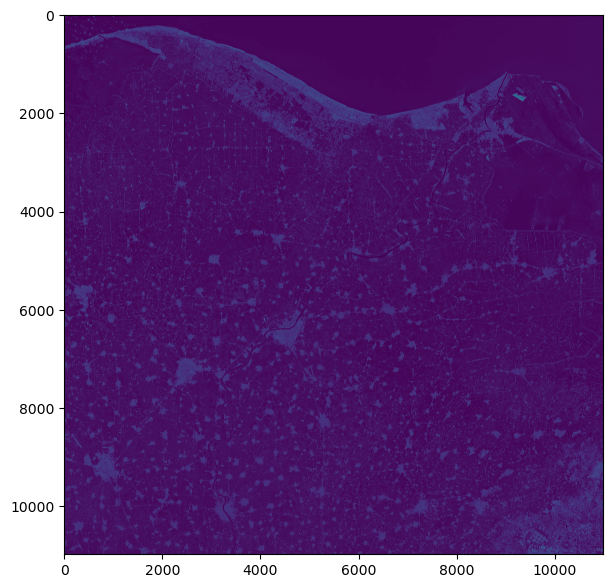

In [9]:
# Open Sharqya raster map classified to agriculture, buildings, water bodies and unclassified
shr_cls = rasterio.open("LU/red_2021-07-07.tif")
plt.figure(figsize=(7,7))
plt.imshow(shr_cls.read(1), cmap = 'viridis')
plt.show()

### Mask the shapefile to the RUV bands and indices images

In [10]:
with fiona.open("shapefile/RUV.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

In [11]:
with rasterio.open("LU/red_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

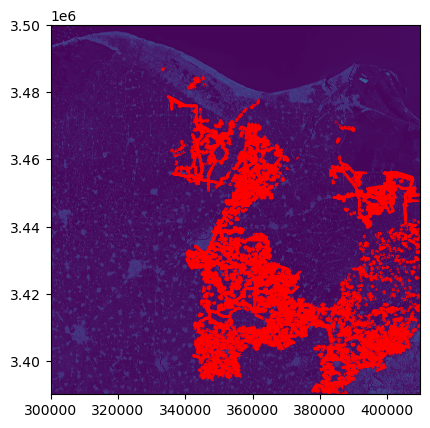

In [12]:
with rasterio.open("LU/red_2021-07-07.tif") as src:
    fig, ax = plt.subplots()
    rasterio.plot.show((src, 1), ax=ax, cmap='viridis')
    patches = [PolygonPatch(feature, edgecolor="red", facecolor="none", linewidth=2) for feature in features]
    ax.add_collection(cplt.PatchCollection(patches, match_original=True))
    plt.show()

In [13]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_red_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

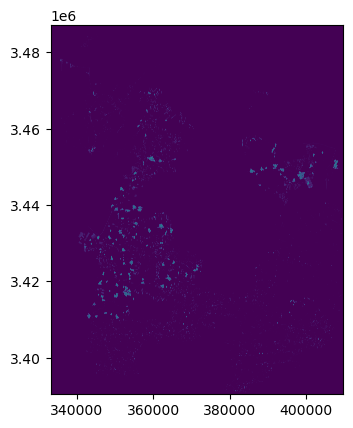

<Axes: >

In [14]:
# Plot the masked file
mas_shr = rasterio.open("images/masked_red_2021-07-07.tif")
rasterio.plot.show((mas_shr), cmap = 'viridis')

#### Apply the crop action for other indices for the same date

In [15]:
# Mask the original tif file
with rasterio.open("LU/blue_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [16]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_blue_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [17]:
# Mask the original tif file
with rasterio.open("LU/green_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [18]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_green_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [19]:
# Mask the original tif file
with rasterio.open("LU/nir_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [20]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_nir_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [21]:
# Mask the original tif file
with rasterio.open("LU/ndvi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [22]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_ndvi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [23]:
# Mask the original tif file
with rasterio.open("LU/kndvi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [24]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_kndvi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [25]:
# Mask the original tif file
with rasterio.open("LU/ndbi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [26]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_ndbi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [27]:
# Mask the original tif file
with rasterio.open("LU/dbsi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [28]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_dbsi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [29]:
# Mask the original tif file
with rasterio.open("LU/savi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [30]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_savi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [31]:
# Mask the original tif file
with rasterio.open("LU/osavi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [32]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_osavi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [33]:
# Mask the original tif file
with rasterio.open("LU/ndwi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [34]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_ndwi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [35]:
# Mask the original tif file
with rasterio.open("LU/mndmi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [36]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_mndmi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [37]:
# Mask the original tif file
with rasterio.open("LU/awei_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [38]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_awei_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [39]:
# Mask the original tif file
with rasterio.open("LU/str11_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [40]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_str11_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [41]:
# Mask the original tif file
with rasterio.open("LU/str12_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [42]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_str12_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [43]:
# Mask the original tif file
with rasterio.open("LU/stravg_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [44]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_stravg_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [45]:
# Mask the original tif file
with rasterio.open("LU/evi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [46]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_evi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

In [47]:
# Mask the original tif file
with rasterio.open("LU/ndpi_2021-07-07.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_profile = src.profile.copy()

In [48]:
# Save the masked result as a tif file
out_profile.update({"driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform})
with rasterio.open("images/masked_ndpi_2021-07-07.tif", 'w', **out_profile) as dst:
    dst.write(out_image)

### Convert shapefile to geotiff image with the class_id value

In [49]:
# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(ruv_shp.geometry, ruv_shp['Class_id']))

In [50]:
print(mas_shr.transform)
print(mas_shr.shape)

| 10.00, 0.00, 333210.00|
| 0.00,-10.00, 3487200.00|
| 0.00, 0.00, 1.00|
(9671, 7659)


In [51]:
print(out_transform)
print(out_image.shape)

| 10.00, 0.00, 333210.00|
| 0.00,-10.00, 3487200.00|
| 0.00, 0.00, 1.00|
(1, 9671, 7659)


In [52]:
# Rasterize vector using the shape and transform of the raster
# "driver": "GTiff", 'width': out_image.shape[2],'height': out_image.shape[1], 'transform': out_transform
rasterized = rasterio.features.rasterize(geom_value,
                                out_shape = (mas_shr.shape[0], mas_shr.shape[1]),
                                transform = mas_shr.transform,
                                all_touched = True,
                                fill = 0,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = int16)

<Axes: >

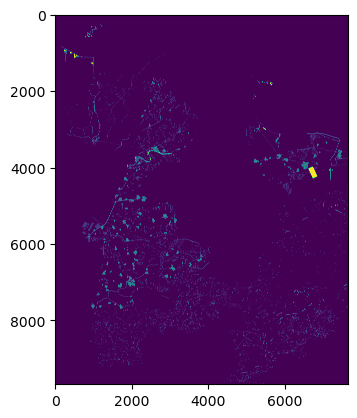

In [53]:
# Plot raster
fig, ax = plt.subplots(1)
show(rasterized, ax = ax)
plt.gca()

In [54]:
# Save the rasterized vector
with rasterio.open(
        "images/vector_shr.tif", "w",
        driver = "GTiff",
        crs = mas_shr.crs,
        transform = mas_shr.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = mas_shr.width,
        height = mas_shr.height) as dst:
    dst.write(rasterized, indexes = 1)

In [55]:
print(dst.transform)
print(dst.shape)

| 10.00, 0.00, 333210.00|
| 0.00,-10.00, 3487200.00|
| 0.00, 0.00, 1.00|
(9671, 7659)
